# <div class="alert alert-info"> 1. Clustering & Dimensionality Reduction</div>

## <font color=red>**1 Introduction**</font>

Clustering is to group similar instances together into clusters. This is a great tool for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning and more

This notebook consolidate common methods for clustering and dimensionality reduction problem

---
# <div class="alert alert-info"> 2. Setup </div>

## <font color=red>**2.1. Import library**</font>

In [1]:
import pandas as pd
import numpy as np

# libraries for visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.colors import ListedColormap, NoNorm
import seaborn as sns
%matplotlib inline

# libraries for clustering and dimensionality reduction
import sklearn
import sklearn.decomposition as dec
import sklearn.cluster as clu
from kmodes.kprototypes import KPrototypes
from sklearn.mixture import GaussianMixture

# supporting libraries
import sklearn.datasets as ds
import sklearn.model_selection as ms
from sklearn.metrics import silhouette_score, adjusted_rand_score, f1_score

# libaries for math & statistics
from scipy import stats
import scipy.io as sio
from scipy.stats import multivariate_normal as mvn
from sklearn.covariance import EllipticEnvelope
from itertools import permutations
# import daft

# Supress warnings
import warnings
warnings.filterwarnings("ignore")
print("Setup complete ...")

C:\Users\Mai\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Setup complete ...


## <font color=red>**2.2. Define function**</font>

In [2]:
def relabel(cl):
    """ Relabel a clustering with three clusters to match the original classes"""
    if np.max(cl) != 2:
        return cl
    perms = np.array(list(permutations((0,1,2))))
    i = np.argmin([np.sum(np.abs(perm[1] - y)) for perm in perms])
    p = perms[i]
    return p[cl]

def plot_cluster(X, y, cluster):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    ax[0].scatter(X[:,0], X[:,1], c=y, s=5, cmap='jet')
    ax[1].scatter(X[:,0], X[:,1], c=cluster, s=5, cmap='jet')
    plt.show()
    
def mapping_cluster_class(y, cluster):
    mapping = {}
    for class_id in np.unique(y):
        mode, _ = stats.mode(cluster[y==class_id])
        mapping[mode[0]] = class_id
    return mapping

---

# <div class="alert alert-info"> 3.  Data Preparation </div>

## <font color=red>**3.1. Import data**</font>

In [3]:
df = pd.read_csv(r'Wine.csv')
print(df.shape)
df.head()

(178, 14)


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


## <font color=red>**3.2. Descriptive Statistics**

In [4]:
df.describe()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,1.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,1.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,1.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,2.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,3.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,3.000000


In [5]:
df.Customer_Segment.value_counts()

2    71
1    59
3    48
Name: Customer_Segment, dtype: int64

1. Dataset has 14 columns and 178 rows
2. All input features are numerica data: 'Alcohol', 'Malic_Acid', 'Ash', 'Ash_Alcanity', 'Magnesium', 'Total_Phenols', 'Flavanoids', 'Nonflavanoid_Phenols', 'Proanthocyanins', 'Color_Intensity', 'Hue', 'OD280', 'Proline'
3. Target variable is: 'Customer_Segment'. There are 3 classes (unique values) in the target var which are 1, 2, 3
4. No missing data

## <font color=red>**3.3. Scaling numeric vars**

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

selected_vars = [x for x in df.columns if x!= 'Customer_Segment']
X = df[selected_vars]
X = X.fillna(X.mean())

scaler = MinMaxScaler(feature_range = (0,1))
X =  pd.DataFrame(scaler.fit_transform(X), columns=selected_vars)
y = df['Customer_Segment']
print(X.shape)
X.head()

(178, 13)


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


---

# <div class="alert alert-info"> 4. Dimensionality Reduction </div>

This section is to demo different Dimensinality Reduction techniques to the dataset and analyze the result which include:
+ PCA
+ SVD
+ Auto Encoder
+ TSN

 ## <font color=red>**4.1. PCA**</font>

 ### <font color=blue>**1. Train model**

In [8]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pd.DataFrame(pca.fit_transform(X))
X_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.706336,-0.253193,0.024093,0.013263,-0.026580,-0.074364,0.065172,0.138519,0.118627,0.277443,0.049711,-0.020012,-0.008723
1,-0.484977,-0.008823,-0.280482,0.075898,-0.238634,-0.071877,0.000686,-0.181193,0.028066,0.114948,0.074158,-0.050838,-0.005249
2,-0.521172,-0.189187,0.196217,-0.015784,0.045045,0.087116,0.125605,0.023178,-0.222133,-0.017270,0.012131,-0.104184,-0.023164
3,-0.821644,-0.580906,0.081110,0.012235,-0.004805,0.081987,-0.068418,-0.152253,-0.009376,0.061897,-0.090261,0.103306,-0.052921
4,-0.202546,-0.059467,0.300240,-0.102051,0.105777,-0.116790,0.057188,-0.009455,0.149605,-0.003043,-0.019021,-0.084094,-0.034172


In [10]:
# inverse PCA to get the original data
inverse_pca = pd.DataFrame(pca.inverse_transform(X_pca))
inverse_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


 ### <font color=blue>**2. Select number of principle components**

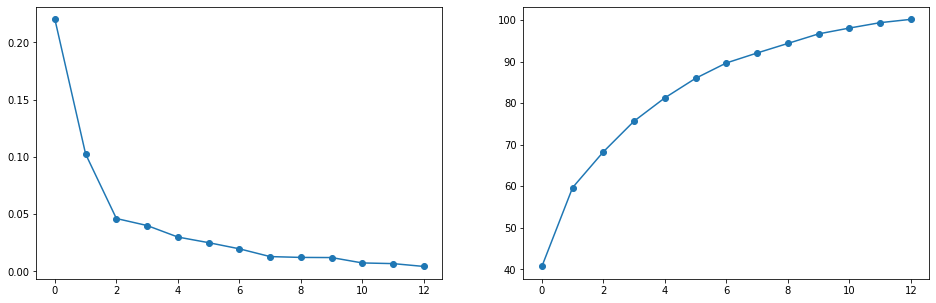

In [12]:
cumsum = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
ax[0].plot(pca.explained_variance_, '-o')
ax[1].plot(cumsum, '-o')
plt.show()

=> The fig on the left side illustrates the variance of each principal component and the fig on the right hand side is the cummulative sum of these principal components. It can be seen from the plot that even the first 4 principal component explains around 75 percent

 ### <font color=blue>**3. Fit and transform features with 75% of variance**

In [13]:
pca = PCA(n_components=0.75)
X_pca = pca.fit_transform(X)
pca.n_components_, pca.n_components, np.sum(pca.explained_variance_ratio_)

(4, 0.75, 0.7570818476302283)

 ### <font color=blue>**4. Plot PCA data with the first 2 components**

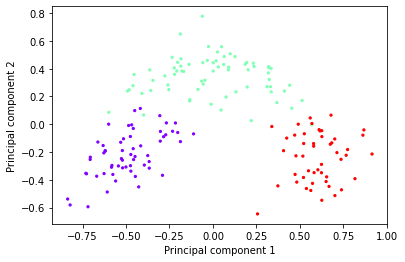

In [16]:
PCA_df = pd.DataFrame(pca.transform(X[selected_vars]))

# Show cluster in 2D space
# cmap = ListedColormap(y)
plt.scatter(PCA_df.iloc[:,0], PCA_df.iloc[:,1], s=5, c=y, cmap=plt.cm.rainbow)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()

 ### <font color=blue>**5. Analysis of principle components**

In [17]:
pca_comp = pd.DataFrame(pca.components_, columns=selected_vars)
pca_comp

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,-0.133368,0.248516,-0.000739,0.177839,-0.088657,-0.395071,-0.414590,0.333109,-0.252902,0.092329,-0.251137,-0.473492,-0.286862
1,-0.550884,-0.227391,-0.163091,0.079776,-0.188166,-0.074145,-0.001007,-0.009960,-0.031418,-0.519707,0.237206,0.215562,-0.443888
2,-0.083848,0.492039,0.403009,0.477242,0.006551,0.253065,0.196105,0.285982,0.228342,-0.033100,-0.106589,0.297776,-0.151968
3,-0.040328,0.486032,-0.241976,-0.081694,0.015880,-0.052643,-0.027033,-0.709095,0.076574,-0.026322,-0.352498,0.082062,-0.229793


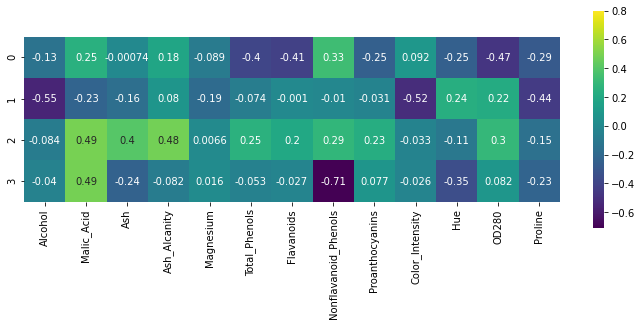

In [18]:
plt.figure(figsize=(12,4))
sns.heatmap(pca_comp, vmax=.8, square=True, annot=True, cmap='viridis')
plt.show()

<Axes: >

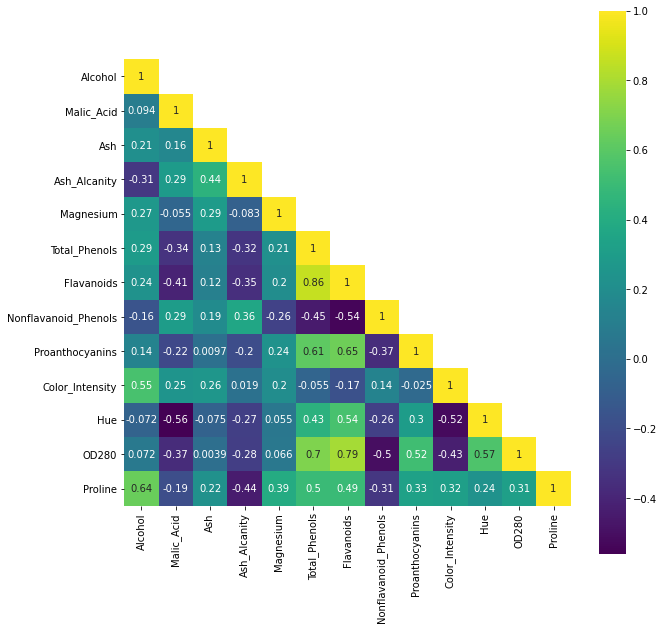

In [19]:
corr_matrix = X.corr()
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, mask=mask, vmax=1, square=True, annot=True, cmap='viridis')

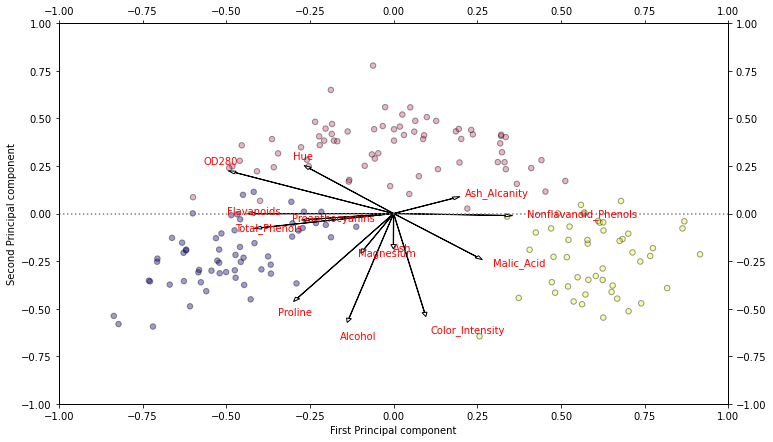

In [20]:
labels = ['Segment1', 'Segment2', 'Segment3']
components = pca_comp.T[[0,1]]
plt.figure(figsize=(12,7))

# main scatter plot
plt.scatter(PCA_df[0], PCA_df[1], c=y, cmap='plasma', alpha=0.4, edgecolors='black', s=30)
plt.xlabel('First Principal component')
plt.ylabel('Second Principal component')
plt.ylim(-1., 1.)
plt.xlim(-1., 1.)

# individual feature values
ax2 = plt.twinx().twiny()
ax2.set_ylim(-1, 1)
ax2.set_xlim(-1, 1)

# reference line
ax2.hlines(0, -1, 1, linestyles='dotted', colors='grey')

# arrow & text
offset = 1.2
for a,i in enumerate(components.index):
    ax2.arrow(0, 0, components[0][a], components[1][a], facecolor='white', head_width=0.015)
    ax2.annotate(i, (components[0][a]*offset, components[1][a]*offset), color='red')
plt.show()

+ For 1st component, coefficients of features Total_Phenols, Flavanoids, OD280, Proline have high negative values (have the same direction which point to the left side) and  coefficients of features Nonflavanoid_Phenols, Malic_Acid have high positive values (have the same direction which point to the right side) . There for the first component can be used to separate data from these 2 groups of features (high negative values vs. high positive values). 
+ For 2nd component, coefficients of features Alcohol, Color_Intensity, Proline have high negative values. The second feature can be used to separate data from this group of features

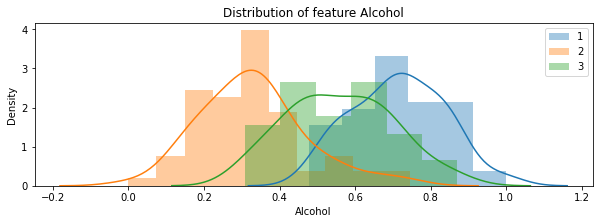

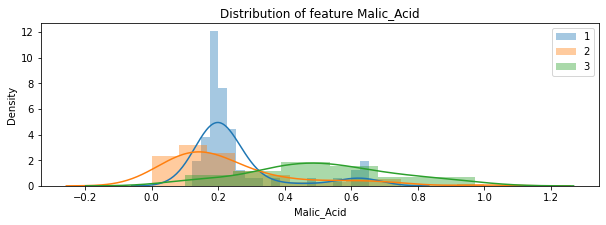

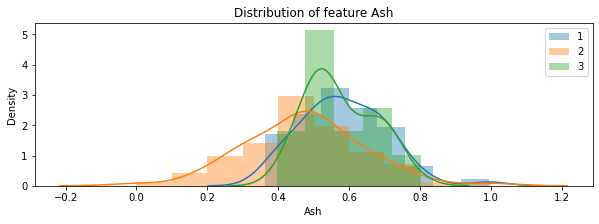

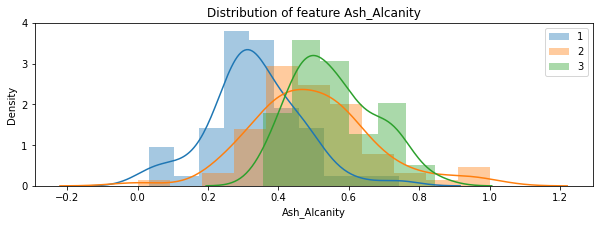

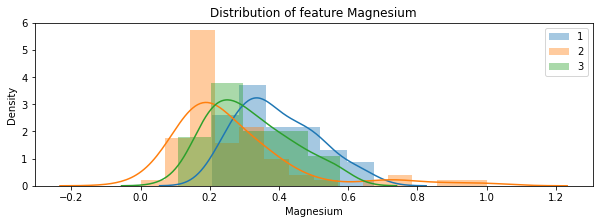

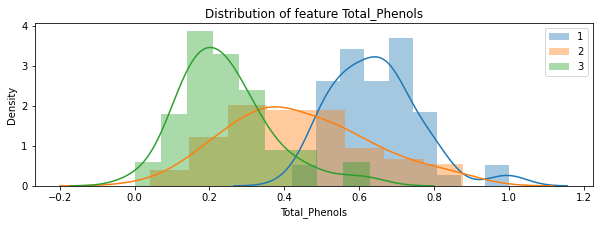

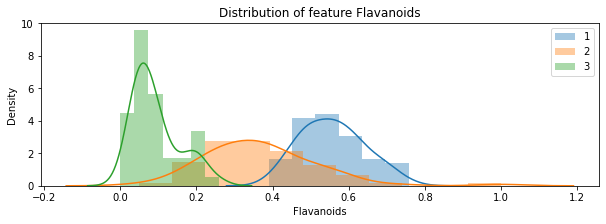

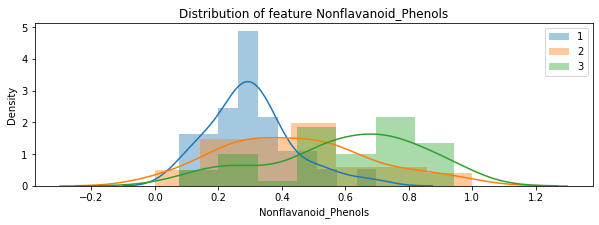

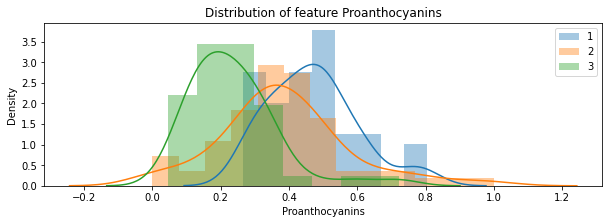

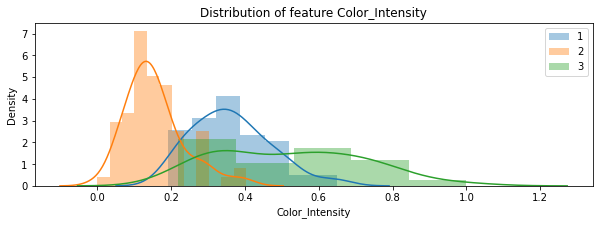

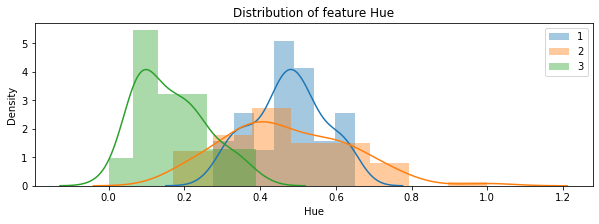

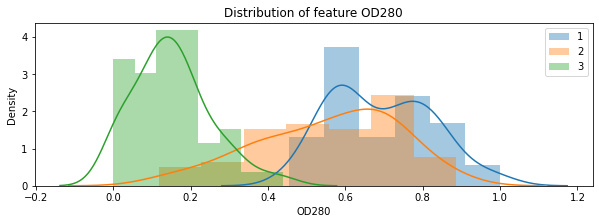

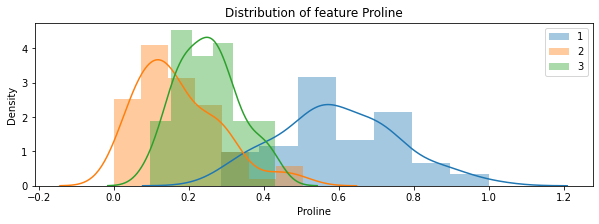

In [21]:
scaled_df = pd.concat([X, y], axis=1)
for col in selected_vars:
    fig, ax = plt.subplots(figsize=(10,3))
    for e in scaled_df['Customer_Segment'].unique():
        sns.distplot(scaled_df[scaled_df['Customer_Segment']==e][col], label=e)
    ax.set_title('Distribution of feature %s' %col)
    plt.legend()
    plt.show()

The plot above shows that 
+ data in class 3 has high negative values for varaibles Total_Phenols, Flavonoids, Hue. Hence these features separate data in class 3 with data in class 1 quite distinctively

+ data is class 1 has high positive values for variables Flavnoids, Proline, OD280

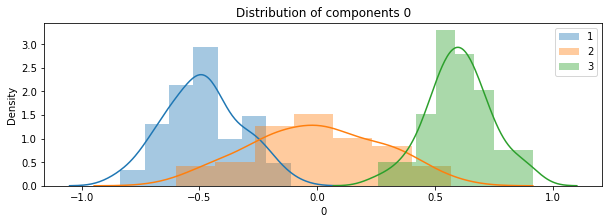

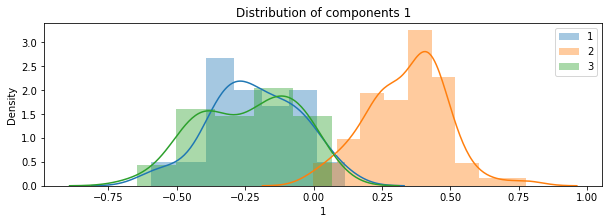

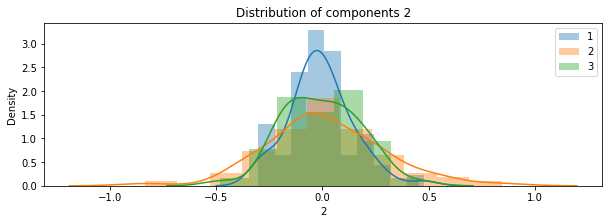

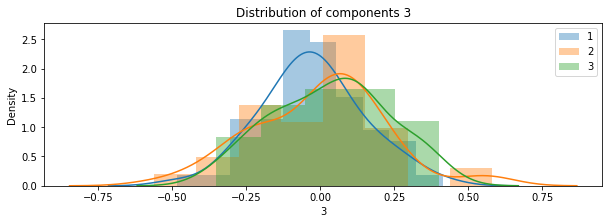

In [22]:
PCA_df = pd.DataFrame(pca.transform(X[selected_vars]))
PCA_df['class'] = y
for col in np.arange(4):
    fig, ax = plt.subplots(figsize=(10,3))
    for e in PCA_df['class'].unique():
        sns.distplot(PCA_df[PCA_df['class']==e][col], label=e)
    ax.set_title('Distribution of components %s' %col)
    plt.legend()
    plt.show()

+ The 1st component separate class 1 and 3 distinctly, with negative values belong to class 1 and positive value belong to class 3. This indicates that class 1 has high values of features Total_Phenols, Flavanoids, OD280, Proline as these features have high negative values of coefficient while class 3 has high values of Nonflavanoid_Phenols, Malic_Acid as these features have high positive values of coefficient

+ The 2nd component separate class 2 from class 1 & 3 with high positive values. As the 2nd component has high negative values of Alcohol, Color_Intensity, Proline, this indicate that in order to to have total high values of component 2, obsevations need to have very small values of Alcohol, Color_Intensity, Proline

Text(0, 0.5, 'PCA 2')

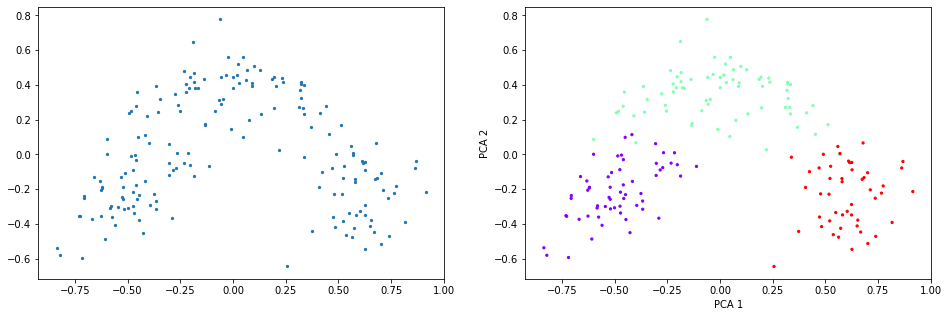

In [25]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,5))
ax[0].scatter(PCA_df[0], PCA_df[1], s=5, cmap=plt.cm.rainbow)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
ax[1].scatter(PCA_df[0], PCA_df[1], s=5, c=y, cmap=plt.cm.rainbow)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

## <font color=red>**4.2.TSNE**</font>

1. t-Distributed Stochastic Neighbor Embedding (t-SNE) is **a non-linear technique for dimensonality reduction** that is particularly well suited for the visualization of high-dimensional datasets. **t-SNE gives us a feel or intuition of how the data is arranged in a high-dimensional space**. 


2. The idea of TSNE is **t-SNE minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding**. In this way, t-SNE maps the multi-dimensional data to a lower dimensional space and attempts to find patterns in the data by indentifying observed clusters based on similarity of data points with multiple features. However, after this process, the input features are no longer identifiable, and you cannot make any inference based only on the output of t-SNE. Hence it is mainly a data exploration and visualization technique.


3. It is highly recommended to use dimensionality reduction method to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.


4. **t-SNE vs. PCA**
    + PCA is a **linear dimension reduction technique** that seeks to **maximize variance and preserves large pairwise distances**. This can lead to poor visulization especially when dealing with non-linear manifold structures such as any geometric shape like: cylinder, ball, curve, etc.
PCA preserves only the global structure of the data. PCA is concerned with preserving large pairwise distances to maximize variance. 
    + TSNE is a **non-linear dimensionality reduction technique** preserves both the local and global structure. It uses the local relationship between data to map the high-dimensional data in two dimensions, **preserving only small pairwise distances or local similarities**. 

 ### <font color=blue>**1. Train model**

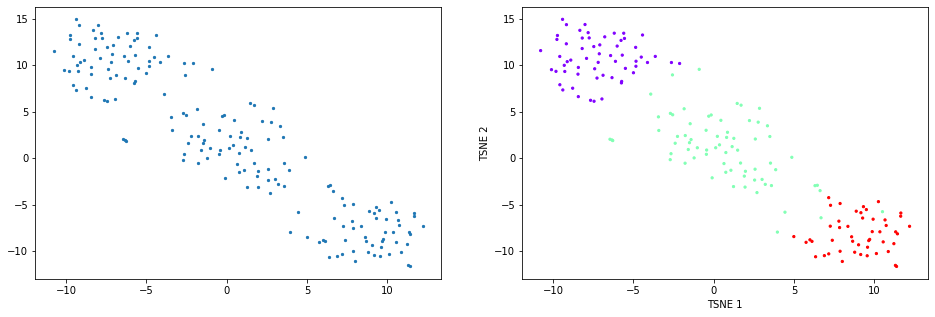

In [24]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=9)
tsne_data = tsne.fit_transform(X[selected_vars])

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,5))
ax[0].scatter(tsne_data[:,0], tsne_data[:,1], s=5, cmap=plt.cm.rainbow)
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
ax[1].scatter(tsne_data[:,0], tsne_data[:,1], s=5, c=y, cmap=plt.cm.rainbow)
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.show()

          0         1         2         3  class
0 -0.706336 -0.253193  0.024093  0.013263      1
1 -0.484977 -0.008823 -0.280482  0.075898      1
2 -0.521172 -0.189187  0.196217 -0.015784      1
3 -0.821644 -0.580906  0.081110  0.012235      1
4 -0.202546 -0.059467  0.300240 -0.102051      1


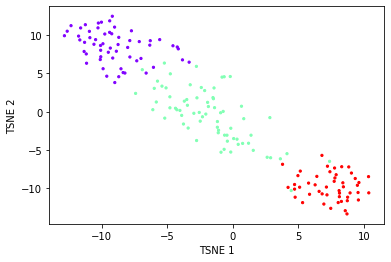

In [26]:
print(PCA_df.head())

tsne = TSNE(n_components=2, random_state=9)
tsne_data = tsne.fit_transform(PCA_df.drop(['class'],axis=1))

plt.scatter(tsne_data[:,0], tsne_data[:,1], s=5, c=y, cmap=plt.cm.rainbow)
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.show()

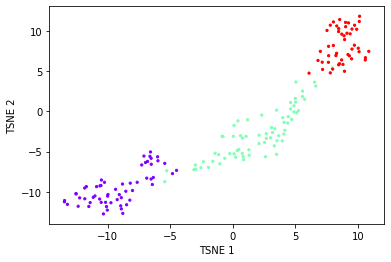

In [27]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=9)
tsne_data = tsne.fit_transform(PCA_df[[0,1]])

plt.scatter(tsne_data[:,0], tsne_data[:,1], s=5, c=y, cmap=plt.cm.rainbow)
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.show()

## <font color=red>**4.3. SVD**</font>

 ### <font color=blue>**1. Train model**

In [28]:
U, S, V = np.linalg.svd(X)
S[0:10]

array([20.35043776,  5.82964479,  3.94740632,  2.70898464,  2.30661666,
        2.12962934,  1.87739348,  1.64518626,  1.47963707,  1.46751136])

 ### <font color=blue>**2. Select number of latent vars**

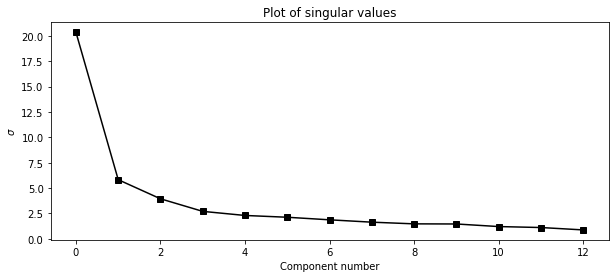

In [29]:
plt.figure(figsize=(10,4))
plt.plot(S, 'ks-')
plt.xlabel('Component number')
plt.ylabel('$\sigma$')
plt.title('Plot of singular values');

In [32]:
svd_comp = pd.DataFrame(V.T, columns=selected_vars)
svd_comp

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,-0.349331,0.059347,-0.470938,0.074291,0.278723,-0.152381,-0.244008,0.520759,-0.126135,0.066326,0.439220,0.046327,0.011729
1,-0.201022,0.379437,-0.024985,-0.652666,0.413245,-0.203149,0.286915,-0.110158,-0.046094,-0.239623,-0.144681,-0.032848,0.031122
2,-0.356013,0.174857,0.076165,0.018152,-0.289031,-0.190711,-0.245457,-0.326495,0.017261,-0.065666,0.228219,-0.608411,-0.350619
3,-0.293224,0.304819,0.344672,-0.139243,-0.420077,-0.078116,-0.312697,0.141485,0.260294,-0.149291,0.056279,0.492797,0.215632
4,-0.215892,0.011129,-0.126984,-0.006962,-0.469696,-0.333164,0.508357,-0.004663,-0.392546,0.407836,-0.026115,0.101340,0.125130
5,-0.312256,-0.281010,-0.003697,-0.088638,0.015497,0.338184,-0.089414,-0.273211,-0.496827,-0.217967,0.039158,0.415437,-0.387224
6,-0.248540,-0.336954,0.029926,-0.080120,-0.004340,0.190649,-0.071384,-0.163397,-0.154845,-0.186421,0.109093,-0.280889,0.774393
7,-0.275821,0.477674,0.295063,0.491955,0.355642,0.293027,0.174044,-0.179244,-0.074559,0.256647,0.066663,0.041774,0.119529
8,-0.252993,-0.162338,0.039422,-0.179447,-0.150173,0.485635,0.498642,0.274406,0.429643,-0.000547,0.249568,-0.118318,-0.180756
9,-0.212896,0.242837,-0.433567,0.025849,-0.201479,0.376069,-0.176857,0.142146,-0.008060,0.024299,-0.670321,-0.152175,0.020212


In [31]:
# list of components selected for the reconstruction
n_comps = np.arange(0,2)
# reconstruct the low-rank version
svd_df = pd.DataFrame(U[:, n_comps]@np.diag(S[n_comps])@V[:,n_comps].T)
print(svd_df.shape)
svd_df.head()

(178, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.786699,-0.305414,0.938177,0.178633,-0.753472,0.400601,0.336933,-0.968886,0.270880,-0.011180,-0.791426,-0.074727,-0.038539
1,0.614855,-0.273274,0.708612,0.209245,-0.614205,0.324656,0.220546,-0.716210,0.209058,0.019077,-0.578755,-0.052445,-0.032561
2,0.732499,-0.235829,0.908129,0.068557,-0.666013,0.356769,0.373798,-0.959753,0.255942,-0.049464,-0.792776,-0.077945,-0.032457
3,0.840270,-0.322334,1.004826,0.182988,-0.801941,0.426584,0.364676,-1.039466,0.289624,-0.015061,-0.849782,-0.080484,-0.040890
4,0.651404,-0.117332,0.873416,-0.125105,-0.524622,0.286377,0.446755,-0.963156,0.234695,-0.118317,-0.811347,-0.085238,-0.022343


Text(0, 0.5, 'Principal component 2')

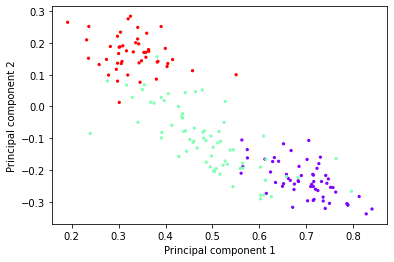

In [33]:
plt.scatter(svd_df.iloc[:,0], svd_df.iloc[:,1], s=5, c=y, cmap = plt.cm.rainbow)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

# <div class="alert alert-info"> 5. Clustering </div>

In [34]:
cluster_df = pd.DataFrame()
cluster_df['y'] = y

 ## <font color=red>**5.1. KMeans**</font>
 
The K-Means algorithm is one of the fastest clustering algorithms, and also one of the simplest
1.	Choose the number of clusters, K stands for the number of clusters
2.	Select randomly k objects from the dataset as the initial cluster centers or means
3.	Calculate Euclidean distance between each point and each cluster (centroid), then assign datapoint to the closet centroid
4.	Adjust/Recalculate the centroids: For each of the k clusters update the cluster centroid by calculating the new mean values of all the data points in the cluster
5.	Repeat the last two steps until we can no longer assign the point to a centroid: Iteratively minimize the total within sum of square in a given cluster. That is, iterate until the cluster assignments stop changing or the maximum number of iterations is reached

 ### <font color=blue>**1. Specifying the optimal number of clusters with Elbow method**</font>

In [37]:
from sklearn.cluster import KMeans

n_clusters = 10
kmeans_per_k = [KMeans(n_clusters=k, random_state=0, init='k-means++').fit(X) for k in range(1, n_clusters)]
wcss = [model.inertia_ for model in kmeans_per_k]

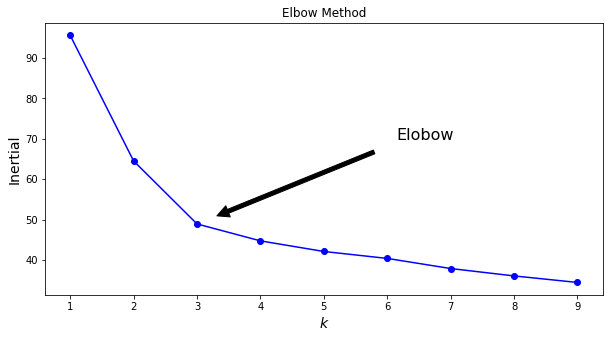

In [38]:
plt.figure(figsize=(10,5))
plt.plot(range(1,10), wcss, 'bo-')
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertial", fontsize=14)
plt.title('Elbow Method')
plt.annotate('Elobow',
            xy=(3, wcss[2]),
            xytext=(0.55, 0.55),
            textcoords='figure fraction',
            fontsize=16, 
            arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

=> There is an elbow at k = 3, which means that less clusters than that would be bad, and more clusters would not help much. 

 ### <font color=blue>**2. Specifying the number of clsuters with Silhoute score**
    
Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

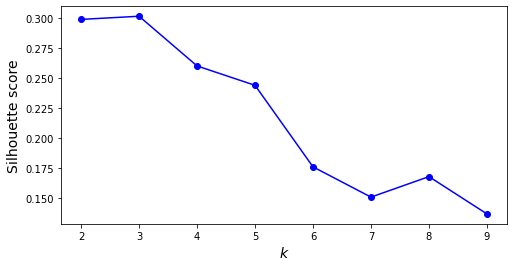

In [39]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

This visualization confirms that $k=3$ has highest Silhouette score, so it is a very good choice

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_:

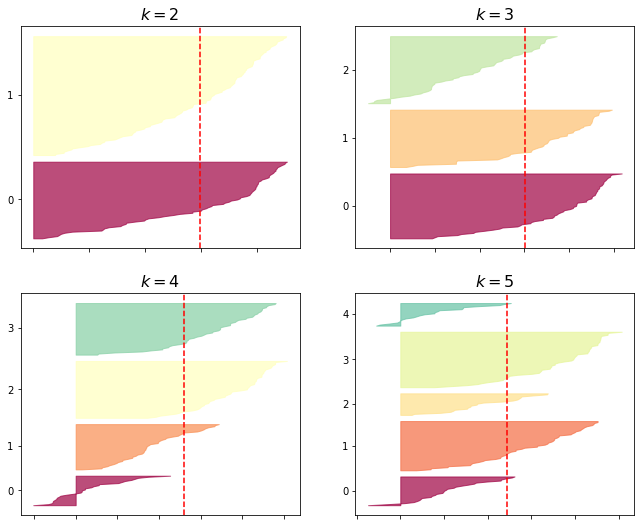

In [40]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2,3,4,5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (8, 10):
        plt.ylabel("Cluster")
    
    if k in (10, 12):
        plt.gca().set_xticks([-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
plt.show()

As suggested from the plot, $k=3$ looks like the best option here, as all clusters are roughly the same size, and they all cross the dashed line, which represents the mean silhouette score.

 ### <font color=blue>**3. Train model**</font>

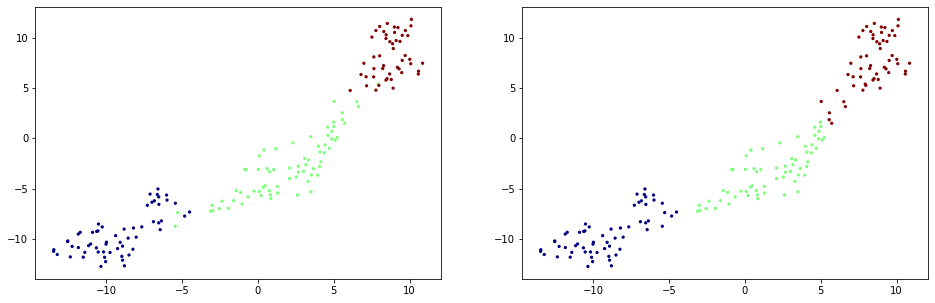

In [41]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3)
km.fit(X)
cluster_df['KMeans'] = km.predict(X)
cluster_class = mapping_cluster_class(y, cluster_df['KMeans'])
cluster_df['KMeans'] = cluster_df['KMeans'].map(cluster_class)
plot_cluster(tsne_data, y, cluster_df['KMeans'])

#### clusters

In [42]:
km.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 2,
       2, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

#### centroids

In [43]:
km.cluster_centers_[0:3]

array([[0.544689  , 0.47844053, 0.56013612, 0.53833177, 0.31146245,
        0.24476489, 0.10713464, 0.61852487, 0.22827646, 0.4826404 ,
        0.19254989, 0.16090576, 0.24739982],
       [0.70565142, 0.24842869, 0.58490401, 0.3444313 , 0.41072701,
        0.64211419, 0.55467939, 0.30034024, 0.47727155, 0.35534046,
        0.47780888, 0.69038612, 0.59389397],
       [0.31137521, 0.23689915, 0.47291703, 0.49991686, 0.2477209 ,
        0.45305895, 0.38240098, 0.4117468 , 0.39742546, 0.14773478,
        0.47351167, 0.58897554, 0.15640099]])

#### inertia metric

In [44]:
km.inertia_

48.960517136676465

In [45]:
from sklearn.metrics import silhouette_score
silhouette_score(X, km.labels_)

0.3008938518500134

 ### <font color=blue>**4. Hard clustering vs. Soft clustering**

Instead of assigning each instance to a single cluster, which is called hard clustering, it can be useful just give each instance a score per cluster - this is called soft clustering. The score can be distance between the instance and the centroid

 ## <font color=red>**5.2. Gaussian Mixture Model**</font>

 ### <font color=blue>**1. Train model**</font>

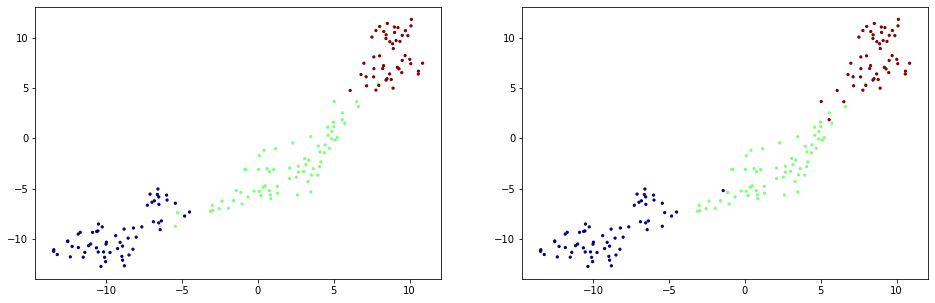

In [46]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=10, random_state=9)
gmm.fit(X)
gmm_prob = gmm.predict_proba(X)
cluster_df['GMM'] = gmm.predict(X)
cluster_class = mapping_cluster_class(y, cluster_df['GMM'])
cluster_df['GMM'] = cluster_df['GMM'].map(cluster_class)
plot_cluster(tsne_data, y, cluster_df['GMM'])

#### Parameters values

In [47]:
gmm.weights_

array([0.36631957, 0.34716488, 0.28651555])

In [48]:
gmm.means_

array([[0.31766496, 0.24540055, 0.47144959, 0.49956639, 0.24480749,
        0.43540097, 0.37079481, 0.43099582, 0.39152302, 0.14976605,
        0.46201505, 0.56818326, 0.15746421],
       [0.70223232, 0.24786544, 0.58321609, 0.34547268, 0.40762967,
        0.63925352, 0.55347444, 0.29969498, 0.47660368, 0.35363791,
        0.47878418, 0.69026227, 0.59017629],
       [0.55294167, 0.48701948, 0.56915219, 0.54295599, 0.32139787,
        0.25152126, 0.09915596, 0.61265253, 0.22211954, 0.5051374 ,
        0.18396234, 0.15248173, 0.25085995]])

Did the algorithm actually converge?

In [49]:
gmm.converged_

True

Yes, good. How many iterations did it take?

In [50]:
gmm.n_iter_

9

 ### <font color=blue>**2.  Specify number of clusters with BIC, AIC**</font>

**BIC, AIC**

In [51]:
gmm.bic(X),  gmm.aic(X)

(-1695.6618051016999, -2694.7418398934146)

In [52]:
n_clusters = 3
n_dims = 13
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gmm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

bic, aic, n_params

(-1695.6618051016999, -2694.7418398934146, 314)

There's one weight per cluster, but the sum must be equal to 1, so we have one degree of freedom less, hence the -1. Similarly, the degrees of freedom for an $n \times n$ covariance matrix is not $n^2$, but $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$.

Let's train Gaussian Mixture models with various values of $k$ and measure their BIC:

In [53]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=9).fit(X) for k in range(1, 6)]

bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

bics

[-1744.2912486476619,
 -1856.0184831103752,
 -1695.6618051016999,
 -1472.5520165883913,
 -1348.6035099738083]

In [54]:
aics

[-2075.1967378780387,
 -2521.011245121421,
 -2694.7418398934146,
 -2805.719324160775,
 -3015.8580903268607]

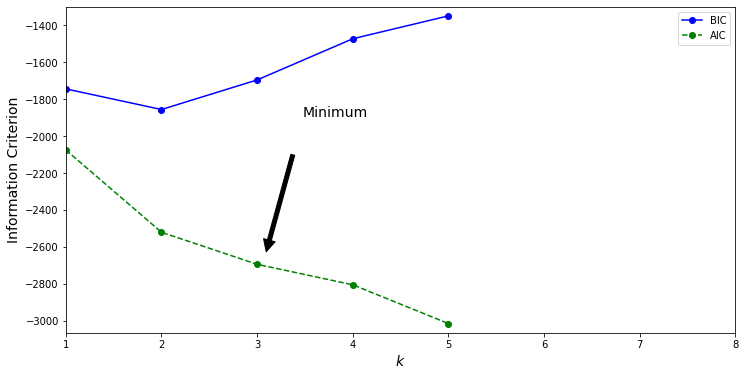

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 6), bics, "bo-", label="BIC")
plt.plot(range(1, 6), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 8, np.min(aics) - 50, np.max(bics) + 50])
plt.annotate('Minimum',
             xy=(3, aics[3]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.2)
            )
plt.legend()
plt.show()

 ### <font color=blue>**3.  Specify number of clusters with lower bound**</font>

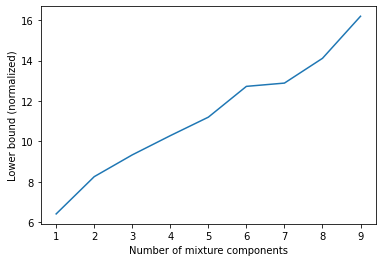

In [56]:
from sklearn.mixture import GaussianMixture
Cs = range(1,10)
lbs = []

for C in Cs:
    gmm = GaussianMixture(n_components=C, n_init=10)
    gmm.fit(X)
    lbs.append(gmm.lower_bound_)
    
plt.plot(Cs, lbs)
plt.xlabel("Number of mixture components")
plt.ylabel("Lower bound (normalized)");

 ## <font color=red>**5.3. Hierarchical Clustering**</font>

 ### <font color=blue>**1. Dendrogram**</font>

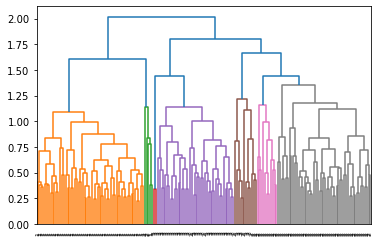

In [57]:
from scipy.cluster.hierarchy import linkage, dendrogram

mergings = linkage(X, method='complete')

dendrogram(mergings, labels=list(y), leaf_rotation=90, leaf_font_size=6);

 ### <font color=blue>**2. Train model**</font>

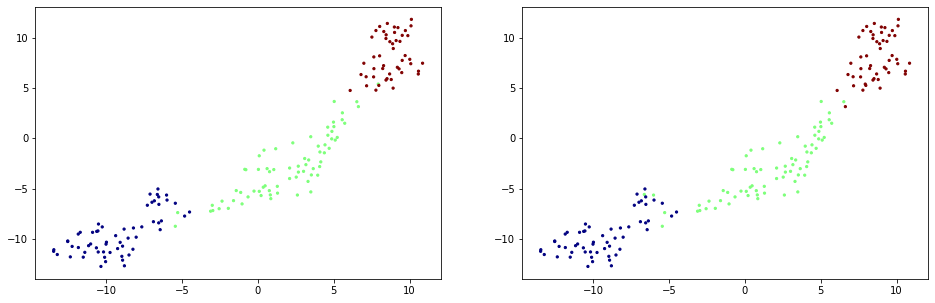

In [58]:
agg = clu.AgglomerativeClustering(3)
agg.fit(X)
cluster_df['Agg'] = agg.fit_predict(X)
cluster_class = mapping_cluster_class(y, cluster_df['Agg'])
cluster_df['Agg'] = cluster_df['Agg'].map(cluster_class)
plot_cluster(tsne_data, y, cluster_df['Agg'])

 ## <font color=red>**5.4. DBSCAN Clustering**</font>

 ### <font color=blue>**1. Train model**</font>

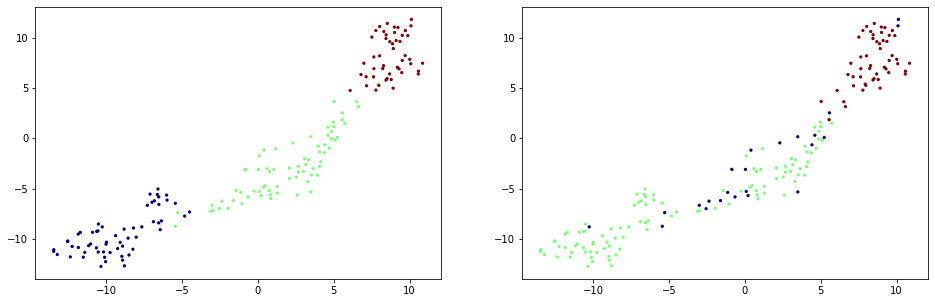

In [59]:
from sklearn.cluster import DBSCAN

# Declaring Model
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fitting
cluster_df['dbs'] = dbscan.fit_predict(X)
#cluster_df.loc[cluster_df.dbs == -1,'dbs'] = 2 
cluster_class = mapping_cluster_class(y, cluster_df['dbs'])
#cluster_df['dbs'] = cluster_df['dbs'].map(cluster_class)
plot_cluster(tsne_data, y, cluster_df['dbs'])

In [60]:
np.unique(dbscan.labels_)

array([-1,  0,  1], dtype=int64)

In [61]:
cluster_df['dbs'].value_counts()

 0    104
 1     51
-1     23
Name: dbs, dtype: int64

In [62]:
len(dbscan.core_sample_indices_)

131

In [63]:
dbscan.core_sample_indices_[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [64]:
dbscan.components_[:3]

array([[0.84210526, 0.1916996 , 0.57219251, 0.25773196, 0.61956522,
        0.62758621, 0.57383966, 0.28301887, 0.59305994, 0.37201365,
        0.45528455, 0.97069597, 0.56134094],
       [0.57105263, 0.2055336 , 0.4171123 , 0.03092784, 0.32608696,
        0.57586207, 0.51054852, 0.24528302, 0.27444795, 0.26450512,
        0.46341463, 0.78021978, 0.55064194],
       [0.56052632, 0.3201581 , 0.70053476, 0.41237113, 0.33695652,
        0.62758621, 0.61181435, 0.32075472, 0.75709779, 0.37542662,
        0.44715447, 0.6959707 , 0.64693295]])

In [65]:
dbscan.components_.shape

(131, 13)

 ### <font color=blue>**2. Find parameters**</font>

In [66]:
dbscan2 = DBSCAN(eps=0.5, min_samples=5)
dbscan2.fit(X)

DBSCAN()

In [67]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

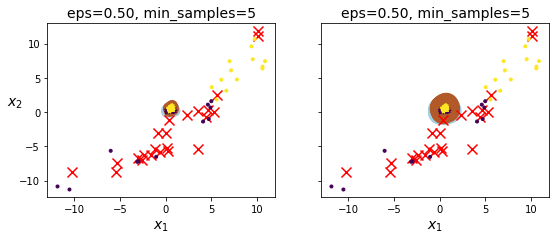

In [68]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, tsne_data, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, tsne_data, size=600, show_ylabels=False)

plt.show()

 ## <font color=red>**5.5. SOM**</font>

 ### <font color=blue>**1. Train model**</font>

In [90]:
# Training the SOM
from minisom import MiniSom
som = MiniSom(x = 50, y = 50, input_len = 13, sigma = 50, learning_rate = 0.008)
som.random_weights_init(X.values)
som.train_random(data = X.values, num_iteration = 1000)

 ### <font color=blue>**2. Visualize results**</font>

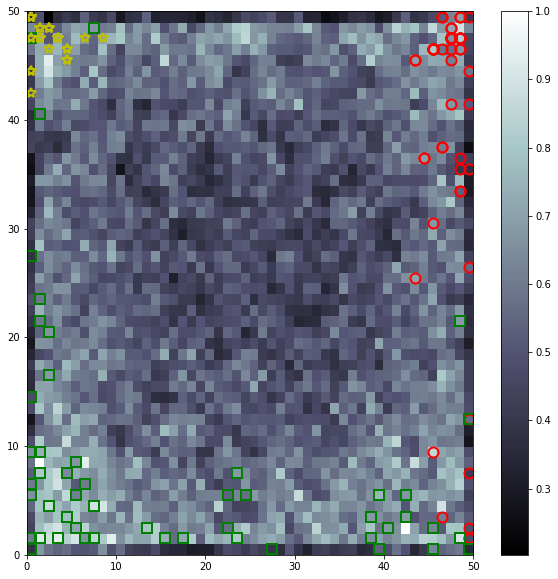

In [91]:
plt.figure(figsize=(10,10))
# Visualizing the results
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's', '*']
colors = ['r', 'g', 'y']
for i, x in enumerate(X.values):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]-1],
         markeredgecolor = colors[y[i]-1],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

# <div class="alert alert-info"> 6.  Try with other algorithms </div>

 ## <font color=red>**6.1. Original data**</font>

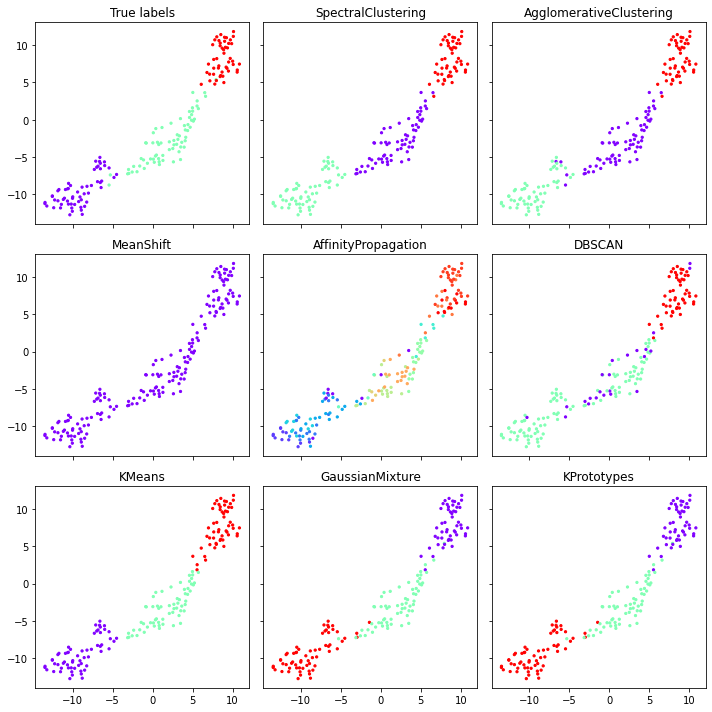

In [92]:
fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)
axes[0, 0].scatter(tsne_data[:,0], tsne_data[:,1], s=5, c=y, cmap=plt.cm.rainbow)
axes[0, 0].set_title("True labels")

for ax, est in zip(axes.flat[1:], [
    clu.SpectralClustering(3),
    clu.AgglomerativeClustering(3),
    clu.MeanShift(),
    clu.AffinityPropagation(),
    clu.DBSCAN(),
    clu.KMeans(3),
    GaussianMixture(n_components=3, n_init=10),
    KPrototypes(n_clusters= 3, init='Cao')
]):
    # est.fit(X_data)
    if(est.__class__.__name__ != 'KPrototypes'):
        c = relabel(est.fit_predict(X[selected_vars]))
    #else:
        c = relabel(est.fit_predict(X[selected_vars]))
    ax.scatter(tsne_data[:,0], tsne_data[:,1], s=5, c=c, cmap=plt.cm.rainbow)
    ax.set_title(est.__class__.__name__)

fig.tight_layout()

 ## <font color=red>**6.2. PCA data**</font>

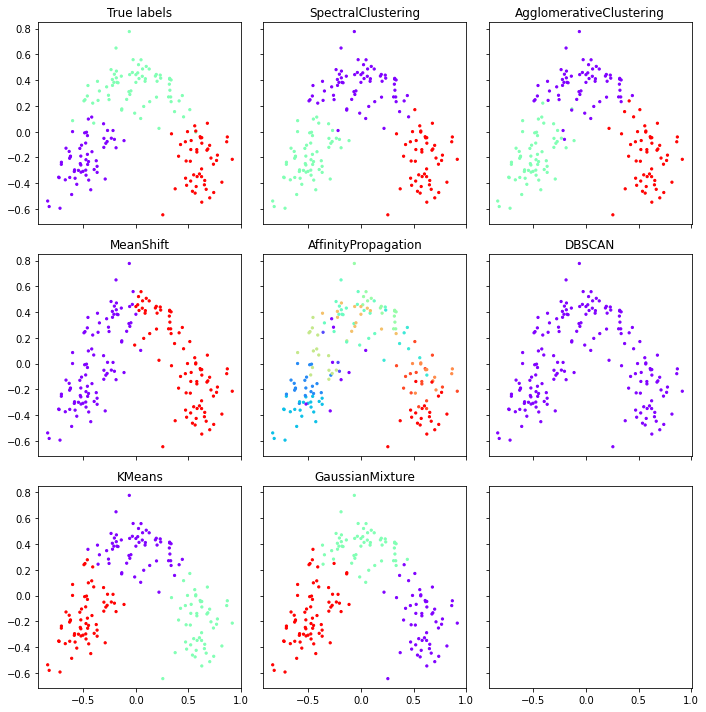

In [93]:
fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)


axes[0, 0].scatter(PCA_df.iloc[:,0], PCA_df.iloc[:,1], s=5, c=y, cmap=plt.cm.rainbow)
axes[0, 0].set_title("True labels")

for ax, est in zip(axes.flat[1:], [
    clu.SpectralClustering(3),
    clu.AgglomerativeClustering(3),
    clu.MeanShift(),
    clu.AffinityPropagation(),
    clu.DBSCAN(),
    clu.KMeans(3),
    GaussianMixture(n_components=3, n_init=10),
    #KPrototypes(n_clusters= 3, init='Cao')
]):
    # est.fit(X_data)
    if(est.__class__.__name__ != 'KPrototypes'):
        c = relabel(est.fit_predict(PCA_df[[0,1,2,3]]))
    #else:
        #c = relabel(est.fit_predict(X[selected_vars]))
    ax.scatter(PCA_df.iloc[:,0], PCA_df.iloc[:,1], s=5, c=c, cmap=plt.cm.rainbow)
    ax.set_title(est.__class__.__name__)

fig.tight_layout()

 ## <font color=red>**6.2. SVD data**</font>

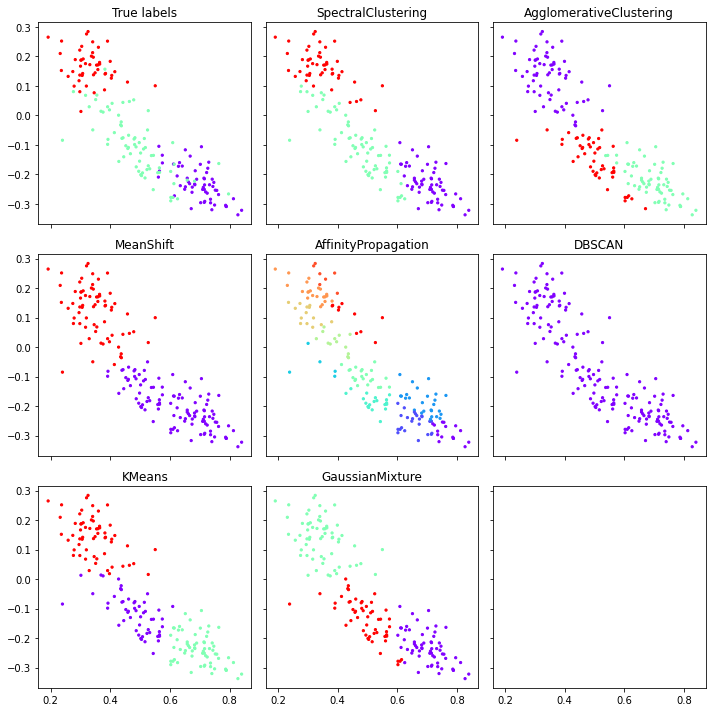

In [94]:
fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)


axes[0, 0].scatter(svd_df.iloc[:,0], svd_df.iloc[:,1], s=5, c=y, cmap=plt.cm.rainbow)
axes[0, 0].set_title("True labels")

for ax, est in zip(axes.flat[1:], [
    clu.SpectralClustering(3),
    clu.AgglomerativeClustering(3),
    clu.MeanShift(),
    clu.AffinityPropagation(),
    clu.DBSCAN(),
    clu.KMeans(3),
    GaussianMixture(n_components=3, n_init=10),
    #KPrototypes(n_clusters= 3, init='Cao')
]):
    # est.fit(X_data)
    if(est.__class__.__name__ != 'KPrototypes'):
        c = relabel(est.fit_predict(svd_df[[0,1,2,3]]))
    #else:
        #c = relabel(est.fit_predict(X[selected_vars]))
    ax.scatter(svd_df.iloc[:,0], svd_df.iloc[:,1], s=5, c=c, cmap=plt.cm.rainbow)
    ax.set_title(est.__class__.__name__)

fig.tight_layout()